In [1]:
%load_ext autoreload
%autoreload 2

# Desiging a synthetic ChiX with imperfect binding to GFP mRNA

## Imports

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.simulator import process_raw_stdout
from synbio_morpher.utils.common.setup import prepare_config, expand_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA, write_fasta_file
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from subprocess import Popen, PIPE

/usr/local/lib/python3.10/dist-packages/jaxtyping/__init__.py:226: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


# Load data

Load ChiX, synChiX, and GFP mRNA.

In [3]:
fn_muts = 'data/scott_mutations.fasta'
fn_fps = 'data/fps.fasta'
fn_all = '../data/sRNA/merged_EcoCyc_RNAInter_sRNATarBase.csv'
fn_tus = '../data/sRNA/EcoCyc/EcoCyc_TUs.csv'

muts = load_seq_from_FASTA(fn_muts, as_type='dict')
fps = load_seq_from_FASTA(fn_fps, as_type='dict')
data = pd.read_csv(fn_all, index_col=0)
tus = pd.read_csv(fn_tus, index_col=0)

In [4]:
fn_sim = './data/tests/2023_12_12_170150/inter_data_raw.json'
sim_data_l = load_json_as_dict(fn_sim)

default_vals = {
    'id1': '', 'id2': '', 'E': 0.0, 'E_norm': 0.0, 'bpList': '', 'hybridDPfull': '', 'seedPu1': '', 'seedPu2': '', 'seedStart1': '', 'seedStart2': '', 'seedEnd1': '', 'seedEnd2': ''
}
mrnas = list(set(flatten_listlike([list(v.keys()) for v in sim_data_l.values()])))
for s, v in sim_data_l.items():
    if len(v.values()) < len(mrnas):
        diffs = set(mrnas) - set(v.keys())
        for d in diffs:
            sim_data_l[s][d] = default_vals
        

In [5]:
sim_data_l['Syn_ChiX_20-D']['cyRFP1']

{'id1': 'cyRFP1',
 'id2': 'Syn_ChiX_20-D',
 'E': '-7.51',
 'E_norm': '-0.676255',
 'bpList': '(392,58):(393,57):(394,56):(395,55):(396,54):(397,53):(401,51):(403,49):(404,48):(405,47):(406,46):(407,45):(408,44):(409,43):(410,42)',
 'hybridDPfull': '.......................................................................................................................................................................................................................................................................................................................................................................................................((((((...(.((((((((.................................................................................................................................................................................................................................................................................................................................&...................

In [6]:
def convert_seed_to_int(seedstr):
    return list(map(lambda x: int(x), seedstr.split(':')))

seed_region = list(map(lambda x: int(x.strip('()').split(',')[-1]), sim_data_l['Syn_ChiX_20-D']['EGFP']['bpList'].split(':')))
seed_region = sorted([seed_region[0], seed_region[-1]])
seed_region

[44, 64]

# Mutate seed region

Do 1, 2, 3, 5, 7, and 10 mutations.

In [7]:
def choose_positions(start, end, bpcount):
    return np.array(np.random.choice(np.arange(start, end), bpcount, replace=False))


def generate_unique_tuples(tot, tup_len, start, end, max_runs=1000):
    unique_tuples = set()
    i = 0
    while len(unique_tuples) < tot or (i > max_runs):
        new_tuple = tuple(np.random.choice(np.arange(start, end), tup_len, replace=False))
        unique_tuples.add(new_tuple)
        i += 1
    return np.array(list(unique_tuples))


def choose_types(seq, positions, nuc_map, nucs, bpcount):
    int_types = np.random.randint(0, len(nucs)-1, bpcount)
    mutation_types = []
    for bp, i in zip(seq[positions], int_types):
        mutation_types.append(nuc_map[bp][i])
    return np.array(mutation_types)


def implement_mutation(mutation_count: int, seq: str, seed_region: tuple, nucs: list, nuc_map: dict, mutations_per_count: int):
    mutations_per_count = np.min([mutations_per_count, np.power(np.diff(seed_region)[0], mutation_count)])
    positions = generate_unique_tuples(tot=mutations_per_count, tup_len=mutation_count, start=seed_region[0], end=seed_region[-1]).T
    mutation_types = choose_types(np.array(list(seq)), positions.flatten(), nuc_map, nucs, bpcount=mutation_count*mutations_per_count)
    mutation_types = mutation_types.reshape((mutation_count, mutations_per_count))

    # seq_ints = np.array(list(map(lambda x: nucs.index(x), seq)))
    mutants = np.repeat(np.array(list(seq))[None, :], repeats=mutations_per_count, axis=1).reshape(
        (len(seq), mutations_per_count)).T
    mut_index = (np.repeat(np.arange(mutations_per_count)[:, np.newaxis], repeats=mutation_count, axis=1).T, positions)
    mutants[mut_index] = mutation_types
    
    assert np.sum((mutants[mut_index] == mutation_types) == False) == 0, 'Mutants have repeting types / positions and are not unique.'
    return mutants

In [8]:
nucs = sorted(['A', 'C', 'G', 'T'])

nuc_map = {}
for n1 in nucs:
    nuc_map[n1] = sorted([n2 for n2 in nucs if n2 != n1])
# nuc_map_ints = {}
# for k, v in nuc_map.items():
#     nuc_map_ints[k] = list(map(lambda x: nucs.index(x), v))

In [9]:
mutation_counts = [1,2,3,5,7,10]
mutations_per_count = 300
seq = muts['Syn_ChiX_20-D']
all_mutants = {}
for mutation_count in mutation_counts:
    all_mutants[mutation_count] = implement_mutation(mutation_count, seq, seed_region, nucs, nuc_map, mutations_per_count)


In [10]:
def pad_integers_with_zeros(num, n):
    return str(num).zfill(n)

highest_iters = len(str(mutations_per_count * max(mutation_counts)))
mutant_fasta = {}
for c, m in all_mutants.items():
    for i, mut in enumerate(m):
        mname = 'SynChiX_mutated_' + str(c) + 'x_id-' + pad_integers_with_zeros(i, highest_iters)
        mutant_fasta[mname] = ''.join(mut)
# mutant_fasta

# Simulate interactions

GFP vs. file with all mutants in it. Set thread count to max.

In [11]:
fn = 'data/15_imperfect_binding/mutants.fasta'
write_fasta_file(out_path = fn, data=mutant_fasta, byseq=True) 

In [12]:
run_intarna = False

config = {
    "experiment": {
        "purpose": "tests",
        },
        "data": {},
        "system_type": "RNA",
        "interaction_simulator": {
            "name": "IntaRNA",
            "postprocess": True,
            "simulator_kwargs": {
                "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
                "threads": 6,
                "n": 1,
                "raw_stdout": True
            }
        }
    }


if run_intarna:
    data_writer = None
    config, data_writer = script_preamble(config, data_writer)
    config = prepare_config(expand_config(config=config))

In [13]:

def simulate_IntaRNA_local(fn_query: str,
                           fn_targets: str,
                           sim_kwargs={}):
    sim_kwargs['query'] = fn_query
    sim_kwargs['target'] = fn_targets

    def run(query: str, target: str, qidxpos0: int, tidxpos0: int, outcsvcols: str, threads: int, n: int = 1,
            param_file: str = '', extra_params: list = [], raw_stdout: bool = False):
        p = Popen(['IntaRNA', '-q', query, '-t', target,
                   '--outMode=C', f'--outcsvcols={outcsvcols}',
                   f'--qIdxPos0={qidxpos0}',
                   f'--tIdxPos0={tidxpos0}',
                   f'--outNumber={n}',
                   f'--threads={threads}', param_file]
                  + extra_params, stdout=PIPE, stderr=PIPE, universal_newlines=True)
        stdout, stderr = p.communicate()
        return process_raw_stdout(stdout)

    return run(**sim_kwargs)


if run_intarna:

    sim_data = simulate_IntaRNA_local(fn_query=fn,
                                      fn_targets=fn_fps,
                                      sim_kwargs=config['interaction_simulator']['simulator_kwargs'])

    data_writer.output(data=sim_data, out_type='json',
                       out_name='inter_data_raw', overwrite=True)
    print(data_writer.write_dir)

In [15]:
fn_sim = 'data/tests/2024_02_21_224902/inter_data_raw.json'
sim_data_l = load_json_as_dict(fn_sim)

default_vals = {
    'id1': '', 'id2': '', 'E': 0.0, 'E_norm': 0.0, 'bpList': '', 'hybridDPfull': '', 'seedPu1': '', 'seedPu2': '', 'seedStart1': '', 'seedStart2': '', 'seedEnd1': '', 'seedEnd2': ''
}
for s, v in sim_data_l.items():
    if len(v.values()) < len(mrnas):
        diffs = set(mrnas.keys()) - set(v.keys())
        for d in diffs:
            sim_data_l[s][d] = default_vals
        

# Pick scale of lowest - highest sRNA binders

In [16]:
sim_df = pd.DataFrame()

i = 0
for k1, v1 in sim_data_l.items():
    for k2, v2 in v1.items():
        sim_df[(k1, k2)] = pd.DataFrame.from_dict({k: [type(default_vals[k])(v)] for k, v in v2.items()}, orient='index')
        i += 1

/tmp/ipykernel_118946/2678600069.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sim_df[(k1, k2)] = pd.DataFrame.from_dict({k: [type(default_vals[k])(v)] for k, v in v2.items()}, orient='index')
/tmp/ipykernel_118946/2678600069.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sim_df[(k1, k2)] = pd.DataFrame.from_dict({k: [type(default_vals[k])(v)] for k, v in v2.items()}, orient='index')
/tmp/ipykernel_118946/2678600069.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

In [17]:
index = pd.MultiIndex.from_tuples(sim_df.columns, names=["fps", "mutant"])
sim_df = pd.DataFrame(data=sim_df.T, index=index, columns =sim_df.index)


In [18]:
sim_df.loc['cyRFP1']

,id1,id2,E,E_norm,bpList,hybridDPfull,seedPu1,seedPu2,seedStart1,seedStart2,seedEnd1,seedEnd2
mutant,,,,,,,,,,,,
SynChiX_mutated_1x_id-0000,cyRFP1,SynChiX_mutated_1x_id-0000,-9.12,-0.815072,"(694,56):(695,55):(696,54):(697,53):(698,52):(...",.................................................,0.45894944370876301:0.44429529732476952:0.4818...,0.16513198844369389:0.16247428888705059:0.2517...,695:696:694,49:48:50,701:702:700,55:54:56
SynChiX_mutated_1x_id-0001,cyRFP1,SynChiX_mutated_1x_id-0001,-5.56,-0.496908,"(453,57):(454,56):(455,55):(456,54):(457,53):(...",.................................................,0.0059331489037627244:0.01251489668783312,0.55760111797565881:0.54862686496753843,463:464,43:42,469:470,49:48
SynChiX_mutated_1x_id-0002,cyRFP1,SynChiX_mutated_1x_id-0002,-7.78,-0.695313,"(452,58):(453,57):(454,56):(455,55):(456,54):(...",.................................................,0.0059331489037627244:0.01251489668783312,0.78397373845086993:0.78397373845086993,463:464,43:42,469:470,49:48
SynChiX_mutated_1x_id-0003,cyRFP1,SynChiX_mutated_1x_id-0003,-7.55,-0.674758,"(452,58):(453,57):(454,56):(455,55):(456,54):(...",.................................................,0.0059331489037627244:0.01251489668783312,0.57599241866214967:0.57599241866214967,463:464,43:42,469:470,49:48
SynChiX_mutated_1x_id-0004,cyRFP1,SynChiX_mutated_1x_id-0004,-5.68,-0.507632,"(452,58):(453,57):(454,56):(455,55):(456,54):(...",.................................................,0.0059331489037627244,0.031048094128300893,463,45,469,51
...,...,...,...,...,...,...,...,...,...,...,...,...
SynChiX_mutated_10x_id-0295,cyRFP1,SynChiX_mutated_10x_id-0295,-7.83,-0.699782,"(702,54):(703,53):(704,52):(705,51):(706,50):(...",.................................................,0.15985936339859338,0.028167970183769511,702,48,708,54
SynChiX_mutated_10x_id-0296,cyRFP1,SynChiX_mutated_10x_id-0296,-9.61,-0.858864,"(230,57):(231,56):(232,55):(233,54):(234,53):(...",.................................................,0.0040194596364592538,0.042950305751680067,230,51,236,57
SynChiX_mutated_10x_id-0297,cyRFP1,SynChiX_mutated_10x_id-0297,-11.75,-1.05012,"(230,63):(231,62):(232,61):(233,60):(234,59):(...",.................................................,0.0033083304618541482:0.0040194596364592538:0....,0.0018150389695636491:0.0019367439884822981:0....,231:230:233:232,56:57:54:55,237:236:239:238,62:63:60:61


In [19]:
sim_df['Mutation count'] = sim_df['id2'].apply(lambda x: x.split('x')[0].split('_')[-1])

# Visualise

Text(0.5, 0.98, 'Mutants generated randomly')

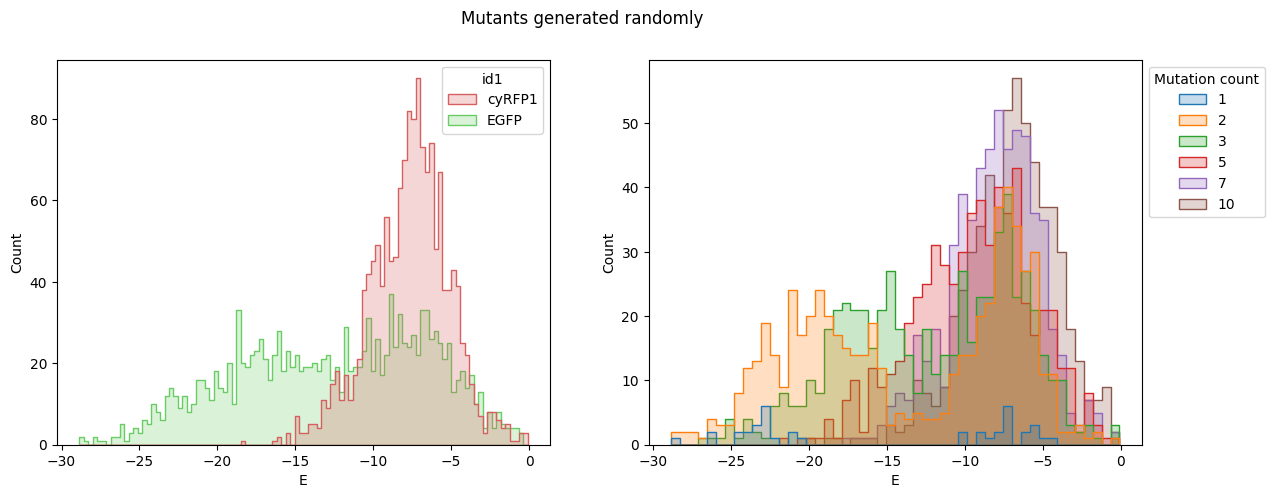

In [20]:
fig = plt.figure(figsize=(2*7, 5))
ax = plt.subplot(1,2,1)
sns.histplot(sim_df, x='E', bins=100, element='step', hue='id1', palette=sns.color_palette("muted")[2:4][::-1])
ax = plt.subplot(1,2,2)
g = sns.histplot(sim_df, x='E', bins=50, element='step', hue='Mutation count')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.suptitle('Mutants generated randomly')